In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os

from astropy.time import Time

from IPython.display import display
from ipywidgets import interact, widgets

Input parameters required:
* Full path to HartRAO data file
* Julian date format for timestamp conversion
* Observation epoch

Expected input format is comma separated data columns containing timeseries of spectra over velocity per channel

In [2]:
input_file = widgets.Text(value='data/iktau/iktausMWch.tscat',
                          placeholder='Type full path to HartRAO data file here',
                          description='filename:',
                          disabled=False,
                          layout={'width':'405px'},
                         )
input_tsfmt = widgets.Dropdown(value='mjd',
                               options=['mjd', 'jd'],
                               description='JD format:',
                               disabled=False,
                               layout={'width':'200px'},
                              )
input_epoch = widgets.Text(value='0',
                           placeholder='epoch',
                           description='epoch:',
                           disabled=False,
                           layout={'width':'200px'},
                          )
options = widgets.HBox([input_tsfmt, input_epoch])
ui = widgets.VBox([input_file, options])
display(ui)

VkJveChjaGlsZHJlbj0oVGV4dCh2YWx1ZT11J2RhdGEvaWt0YXUvaWt0YXVzTVdjaC50c2NhdCcsIGRlc2NyaXB0aW9uPXUnZmlsZW5hbWU6JywgbGF5b3V0PUxheW91dCh3aWR0aD11JzQwNXDigKY=


In [3]:
filename = input_file.value
tsformat = input_tsfmt.value
epoch = float(input_epoch.value)
print("Reading OH monitoring file {} using epoch {} and '{}' format for time interpretation".
      format(filename, epoch, tsformat))

Reading OH monitoring file data/iktau/iktausMWch.tscat using epoch 0.0 and 'mjd' format for time interpretation


OH monitoring data files are comma spearated (CSV) ASCII files tabulating the observed data.
The files have the following structure: 
* Line 0: a human readable string for information
* Line 1: a header line containing the timestamps followed by the channel velocities per column
* Line 2-N: timeseries data with a timestamp in the format indicated by the header in the first column, followed by the per channel spectra value

Layout of data per row:
* First column is timestamps in DJ - epoch
* Remaining columns are spectral channels

In [4]:
import hart_io as io
# read input data assuming HartRAO format
[header,
 chan_vel,
 timestamps,
 spectra,
 ts_jd] = io.input(filename,
                   epoch=epoch,
                   tsformat=tsformat)
avg_spectra = spectra.mean(axis=0)

In [5]:
# human readable string for information
# timestamps [channel velocities]
print(header)
print('Spectral data size (#ts, #ch) = ({}, {})'.format(timestamps.size, spectra.shape[1]))
[comment, head_line] = header.strip().split('\n')

IKTAU        OH1612 time series of intensities F from iktaus.sf85
MJD,              15.973,      16.438,      16.903,      17.368,      17.832,      18.297,      18.762,      19.227,      19.692,      20.157,      46.190,      46.654,      47.119,      47.584,      48.049,      48.514,      48.979,      49.444,      49.909,      50.373,      50.838,      51.303,

Spectral data size (#ts, #ch) = (170, 22)


Assuming the double-peaked profile of the velocity spectrum for the OH masers, identify the brightest blue- and red-shifted peaks representing the radiation arising from the near- and far-sides of the dust shell along the line of sight.

From the spectrum averaged over time for all channels, identify the maximum strength blue shifted and red shifted channels.
If the identified channels are located on a flat peak, 2 or 3 consecutive channels are average for robustness.




In [6]:
# average over a couple of channels around peak if flat max
def peak_channels(spectrum, channel, threshold=0.9):
    channels = np.array([channel])
    if (spectrum[channel-1]/spectrum[channel]) > threshold:
        channels = np.hstack([channel-1, channels])
    if (spectrum[channel+1]/spectrum[channel]) > threshold:
        channels = np.hstack([channels, channel+1])
    return channels

def guess_channels(avg_spectra, chan_vel):
    cen_channel = len(chan_vel)//2
    max_blue_idx = np.argmax(avg_spectra[:cen_channel])
    blue_ch_idx = peak_channels(avg_spectra,
                                channel=max_blue_idx)
    max_red_idx = cen_channel + np.argmax(avg_spectra[cen_channel:])
    red_ch_idx = peak_channels(avg_spectra,
                               channel=max_red_idx)
    return max_blue_idx, blue_ch_idx, max_red_idx, red_ch_idx

In [7]:
[max_blue_idx, blue_ch_idx,
 max_red_idx, red_ch_idx] = guess_channels(avg_spectra, chan_vel)
max_blue_ch =  max_blue_idx + 1
max_red_ch =  max_red_idx + 1

In [8]:
blue_chan = widgets.Text(value=str(max_blue_ch),
                         placeholder='Blue peak',
                         description='Blue channel',
                         disabled=False,
                         layout={'width':'200px'},
                        )
red_chan = widgets.Text(value=str(max_red_ch),
                        placeholder='Red peak',
                        description='Red channel',
                        disabled=False,
                        layout={'width':'200px'},
                       )
channels = widgets.HBox([blue_chan, red_chan])
display(channels)

SEJveChjaGlsZHJlbj0oVGV4dCh2YWx1ZT11JzQnLCBkZXNjcmlwdGlvbj11J0JsdWUgY2hhbm5lbCcsIGxheW91dD1MYXlvdXQod2lkdGg9dScyMDBweCcpLCBwbGFjZWhvbGRlcj11J0JsdWXigKY=


In [9]:
# update after user input if provided
if int(blue_chan.value) != max_blue_ch:
    max_blue_ch = int(blue_chan.value)
    max_blue_idx = max_blue_ch - 1
    blue_ch_idx = peak_channels(avg_spectra,channel=max_blue_idx)

if int(red_chan.value) != max_red_ch:
    max_red_ch = int(red_chan.value)
    max_red_idx = max_red_ch - 1
    red_ch_idx = peak_channels(avg_spectra,channel=max_red_idx)

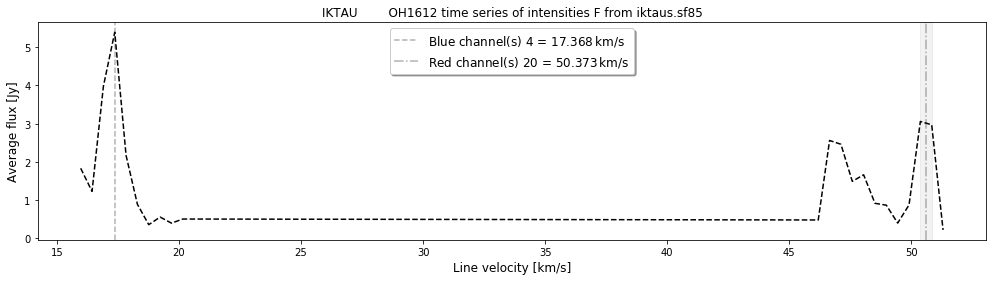

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(chan_vel, avg_spectra, 'k--')
if len(blue_ch_idx) > 1:
    ax.axvspan(np.min(chan_vel[blue_ch_idx]),
              np.max(chan_vel[blue_ch_idx]),
              color='k',
              alpha=0.05,
             )
if len(red_ch_idx) > 1:
    ax.axvspan(np.min(chan_vel[red_ch_idx]),
              np.max(chan_vel[red_ch_idx]),
              color='k',
              alpha=0.05,
             )
ax.axvline(x=chan_vel[blue_ch_idx].mean(),
           color='k',
           linestyle='--',
           alpha=0.3,
           label=r'Blue channel(s) {} = {}$\,$km/s'.format(max_blue_ch, chan_vel[max_blue_idx]),
          )
ax.axvline(x=chan_vel[red_ch_idx].mean(),
           color='k',
           linestyle='-.',
           alpha=0.3,
           label=r'Red channel(s) {} = {}$\,$km/s'.format(max_red_ch, chan_vel[max_red_idx]),
          )

title = comment.strip()
ax.set_title(title, fontsize=12)
ax.set_xlabel('Line velocity [km/s]', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=1,
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)

fig_name = os.path.splitext(os.path.basename(filename))[0]
plt.savefig('{}_spectrum.png'.format(fig_name),
            bbox_inches='tight')

plt.show()

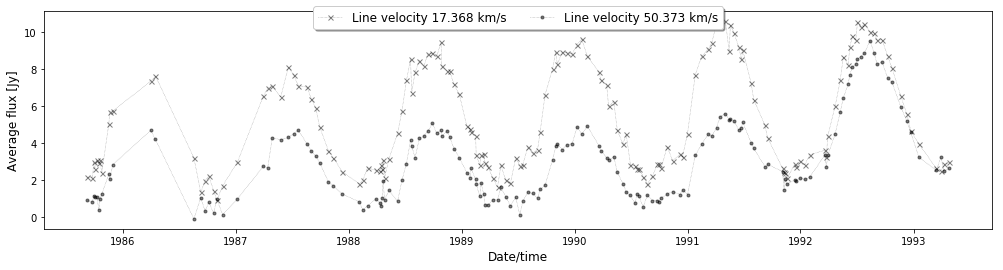

In [11]:
blue_spectrum = spectra[:, blue_ch_idx].mean(axis=1)
red_spectrum = spectra[:, red_ch_idx].mean(axis=1)
jd_datetime = ts_jd.datetime

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 4),
                       facecolor='white')
ax.plot(jd_datetime, blue_spectrum,
        color='k', marker='x', linestyle=':', linewidth=0.5, markersize=5,
        label = 'Line velocity {} km/s'.format(chan_vel[max_blue_idx]),
        alpha=0.5)
ax.plot(jd_datetime, red_spectrum,
        color='k', marker='.', linestyle=':', linewidth=0.5, markersize=6,
        label = 'Line velocity {} km/s'.format(chan_vel[max_red_idx]),
        alpha=0.5)

ax.set_xlabel('Date/time', fontsize=12)
ax.set_ylabel('Average flux [Jy]', fontsize=12)

ax.legend(ncol=2,
          loc='upper center',
          bbox_to_anchor=(0.5, 1.05),
          numpoints=1,
          fancybox=True,
          shadow=True,
          fontsize=12)

plt.xticks(fontsize=10, rotation=0)
plt.yticks(fontsize=10)

fig_name = os.path.splitext(os.path.basename(filename))[0]
plt.savefig('{}_ts_blue{}_red{}.png'.format(fig_name, max_blue_ch, max_red_ch),
            bbox_inches='tight')

plt.show()

In [12]:
outfile = os.path.basename(filename)
[name, ext] = os.path.splitext(outfile)
outfile = '{}_blue_red_channels{}'.format(name, ext)

[comment, head_line] = header.strip().split('\n')
comment ='{}\n'.format(comment.strip())
comment += '{}, {:.3f}, {:.3f}\n'.format(head_line.split(',')[0], chan_vel[max_blue_idx], chan_vel[max_red_idx])

show_spectra = np.vstack([blue_spectrum, red_spectrum]).T
io.output(outfile, comment, timestamps, show_spectra)

## 3D plots for presentations

In [13]:
(x, y) = np.meshgrid(np.asarray(timestamps, dtype=float), chan_vel)
z = spectra.T

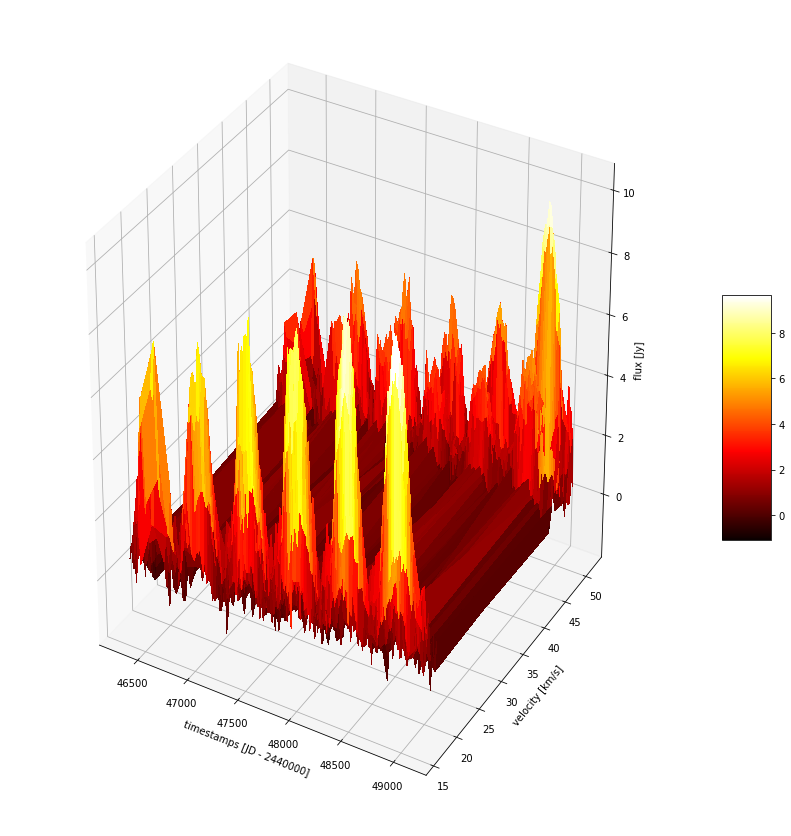

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15), facecolor='white')
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x,y,z, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.3, aspect=5)
ax.set_xlabel('timestamps [JD - 2440000]')
ax.set_ylabel('velocity [km/s]')
ax.set_zlabel('flux [Jy]')
plt.show()

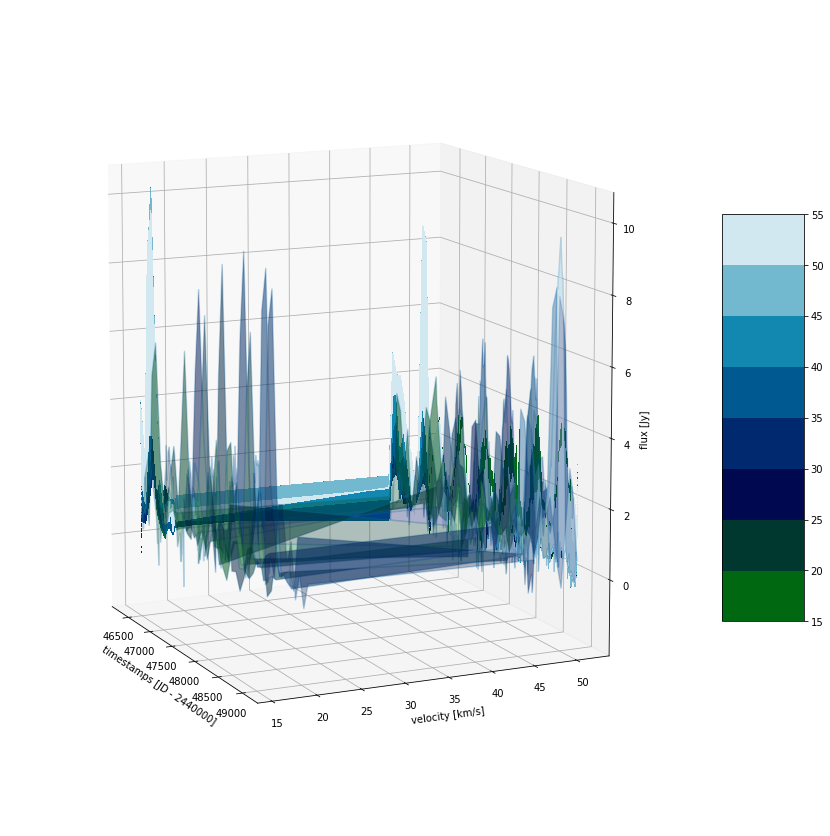

In [15]:
from matplotlib import cm
fig = plt.figure(figsize=(15, 15), facecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
ax.plot_surface(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
cset = ax.contourf(x, y, z, zdir='x', offset=np.min(x), cmap=cm.ocean)
cset = ax.contourf(x, y, z, zdir='y', offset=np.max(y), cmap=cm.ocean)
fig.colorbar(cset, ax=ax, shrink=0.5, aspect=5)
ax.view_init(10, -25)
ax.set_xlabel('timestamps [JD - 2440000]')
ax.set_ylabel('velocity [km/s]')
ax.set_zlabel('flux [Jy]')
plt.show()

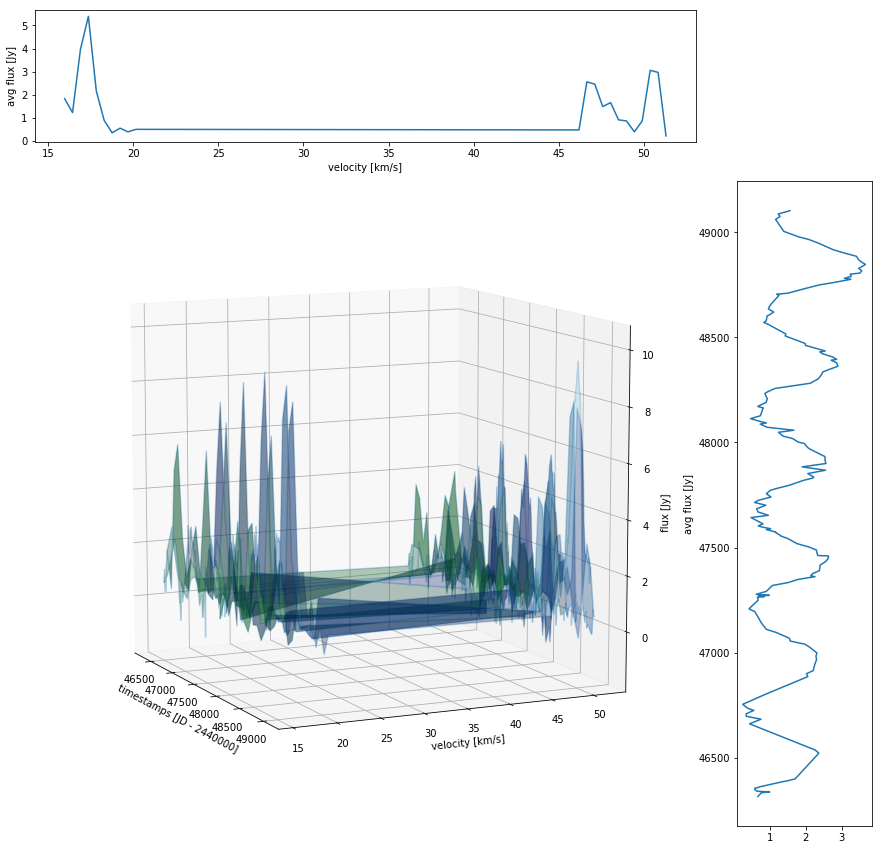

In [16]:
from matplotlib import gridspec
fig= plt.subplots(figsize=(15,15), facecolor='white')
gs = gridspec.GridSpec(5, 5, hspace=0.3, wspace=0.3)
ax0 = plt.subplot(gs[0, :-1])
ax0.plot(chan_vel, spectra.mean(axis=0))
ax0.set_xlabel('velocity [km/s]')
ax0.set_ylabel('avg flux [Jy]')

ax1 = plt.subplot(gs[1:, :-1], projection='3d')
ax1.plot_wireframe(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
ax1.plot_surface(x, y, z, rstride=10, cstride=10, cmap=cm.ocean, alpha=0.3)
ax1.view_init(10, -25)
ax1.set_xlabel('timestamps [JD - 2440000]')
ax1.set_ylabel('velocity [km/s]')
ax1.set_zlabel('flux [Jy]')

ax2 = plt.subplot(gs[1:, -1])
ax2.plot(spectra.mean(axis=1), timestamps)
ax2.set_ylabel('timestamps [JD - 2440000]')
ax2.set_ylabel('avg flux [Jy]')
plt.show()